In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
#import h5py
from skimage.transform import resize

# import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl

In [2]:
tf.enable_eager_execution()

In [3]:
execfile("AE_RIM_definitions.py")

In [4]:
batch_size = 50
npix_side = 512

In [5]:

# input_filename = '/mnt/home/yhezaveh/_Censai_local/data/KAP_001_normalized.mat'

# mat_contents = scipy.io.loadmat(input_filename)
# kappa = mat_contents['KAP']

# kappa = np.moveaxis( kappa , 0 , 2)
# kappa = resize(kappa, (npix_side,npix_side), order=1, preserve_range=True)
# kappa = np.moveaxis( kappa , 2 , 0)

In [8]:
from PIL import Image

def data_batch(batch_size):
    SRC = np.zeros((batch_size,212,212))
    #while math.isnan(np.max(SRC))
    inds = np.random.randint(1, high = 9999 , size= batch_size)
    for i in range(batch_size):
        SRC[i,:,:] = np.array(Image.open('/mnt/home/llevasseur/Censai/notebooks/auto_encoding_rim/data/for_python/src_' +  "%07d" % (inds[i]) +'.png'),dtype='float32')/65535.0
    SRC = np.moveaxis( SRC , 0 , 2)
    SRC = resize(SRC, (npix_side,npix_side), order=1, preserve_range=True)
    SRC = np.moveaxis( SRC , 2 , 0)        
    for i in range(batch_size):
        SRC[i,:,:] = SRC[i,:,:] / np.max(SRC[i,:,:])
    return SRC

In [14]:
VAE_obj = VAE(n_latent = 64 , npix_side = npix_side)

In [17]:
load_checkpoint_path = "checkpoints/model_VAE_512"
save_checkpoint_path = "checkpoints/model_VAE_512_SRC"
RESTORE = True
if (RESTORE==True):
    VAE_obj.load_weights(load_checkpoint_path)

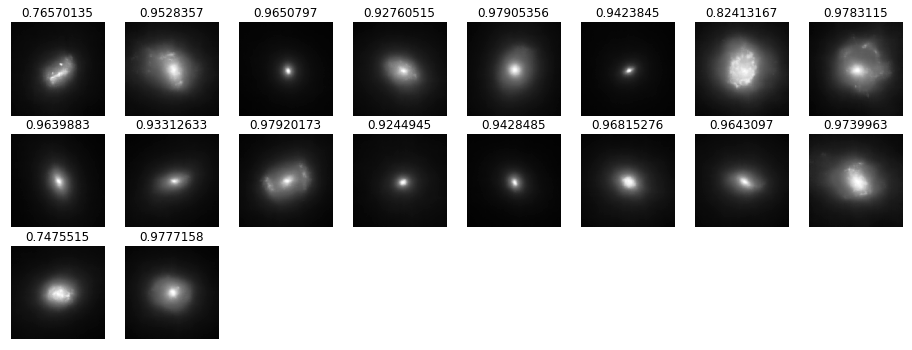

In [18]:
with tf.device('/gpu:0'):
    ims = VAE_obj.draw_image(18)
    fig = plot(ims)
    #plt.savefig('out_conv/{}.png'.format(str(im_i).zfill(3)), bbox_inches='tight')
    #plt.close(fig)



In [ ]:
# def plot(samples):
#     fig = plt.figure(figsize=(26*6, 26*3))
#     gs = gridspec.GridSpec(3, 6)
#     gs.update(wspace=None, hspace=None)

#     for i, sample in enumerate(samples):
#         ax = plt.subplot(gs[i])
#         plt.axis('off')
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.set_aspect('equal')
#         plt.imshow(sample, cmap='Greys_r')
#         #plt.title(str(np.max(sample)))
#     return fig



In [ ]:
# fig = plot(ims[0:18])
# plt.savefig('FIG2.png', bbox_inches='tight')
# plt.close(fig)

In [1]:
optimizer = tf.train.AdamOptimizer(1e-4)

NameError: name 'tf' is not defined

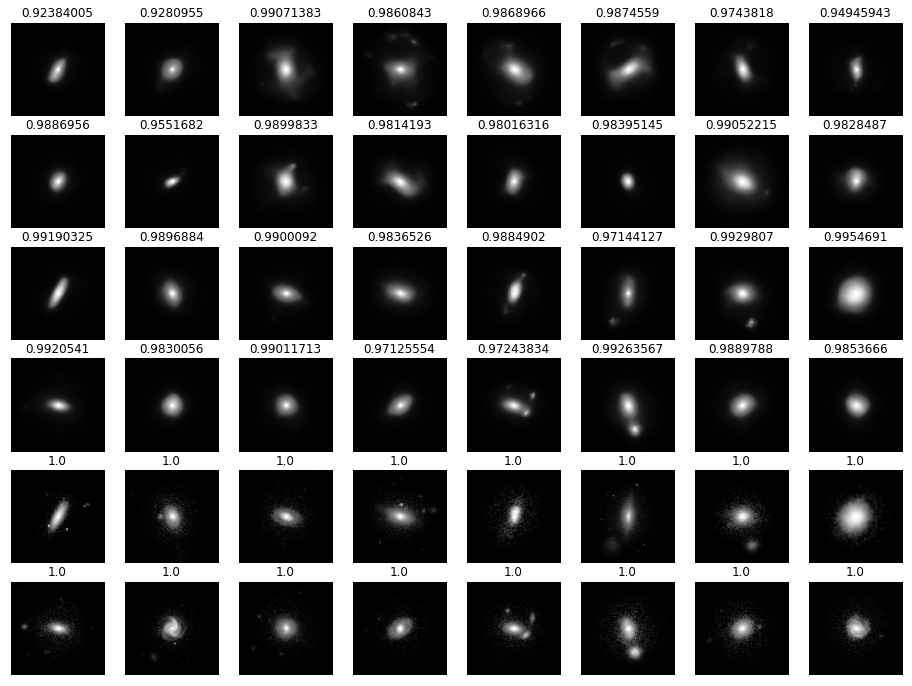

42100
42101
42102
42103
42104
42105
42106
42107
42108
42109
42110
42111
42112
42113
42114
42115
42116
42117
42118
42119
saving weights.
done.


KeyboardInterrupt: 

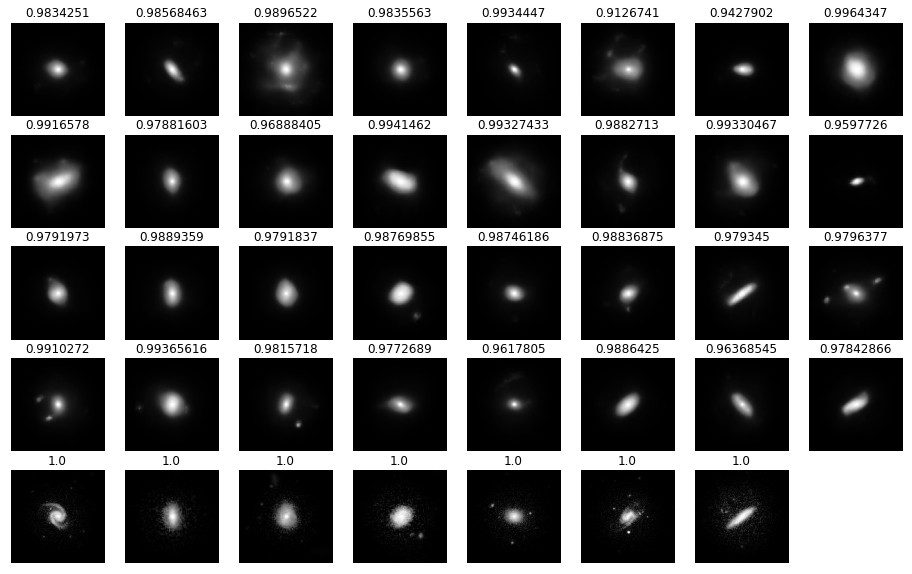

In [22]:
im_i = 0
with tf.device('/gpu:0'):
    for train_iter in range(10000000):
        print train_iter
        #ind = np.random.randint(0, high=1500, size=batch_size)
        #batch_kappa = kappa[ind,:].reshape((-1,npix_side,npix_side))
        #batch_kappa = tf.cast( batch_kappa , datatype)

        batch_kappa = data_batch(batch_size)
        batch_kappa = tf.cast( batch_kappa , datatype)

        
        with tf.GradientTape() as tape:
            tape.watch(VAE_obj.variables)
            cost_value , decoded_im = VAE_obj.cost(batch_kappa)
        weight_grads = tape.gradient(cost_value, [VAE_obj.variables] )

        clipped_grads = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
        optimizer.apply_gradients(zip(clipped_grads, VAE_obj.variables), global_step=tf.train.get_or_create_global_step())

        if (((train_iter+1)%20)==0):
            im_i = im_i + 1
            print( "saving weights." )
            VAE_obj.save_weights(save_checkpoint_path)
            print( "done." )
            ims = VAE_obj.draw_image(16)
            ims = [np.reshape(ims[i].numpy(), [npix_side, npix_side]) for i in range(16)] + [np.reshape(decoded_im[i,:,:], [npix_side, npix_side]) for i in range(16)] + [np.reshape(batch_kappa[i,:,:], [npix_side, npix_side]) for i in range(16)]
            pl.clf()
            fig = plot(ims)
            display.clear_output(wait=True)
            display.display(pl.gcf())



In [ ]:
# batch_kappa = kappa[ind,:].reshape((-1,npix_side,npix_side))
# batch_kappa = tf.cast( batch_kappa , datatype)




In [ ]:
# batch_src = data_batch(batch_size)
# batch_src = tf.cast( batch_src , datatype)




In [ ]:
tf.reduce_max(batch_kappa[0])